# The Curse of Dimensionality

An increase in the number of dimensions of a dataset means that there are more entries in the vector of features that represents each observation in the corresponding Euclidean space. We measure the distance in a vector space using Euclidean distance, also known as L2 norm, which we applied to the vector of linear regression coefficients to train a regularized Ridge Regression model.

The Euclidean distance between two n-dimensional vectors with Cartesian coordinates p = (p1, p2, ..., pn) and q = (q1, q2, ..., qn) is computed using the familiar formula developed by Pythagoras:
$$d(p, q)=\sqrt{\sum_{i=1}^n(p_i−q_i)^2}$$

Hence, each new dimension adds a non-negative term to the sum, so that the distance increases with the number of dimensions for distinct vectors. In other words, as the number of features grows for a given number of observations, the feature space becomes increasingly sparse, i.e., less dense or emptier. On the flip side, the lower data density requires more observations to keep the average distance between data points the same.

In [1]:
import pandas as pd
import numpy as np
from numpy import clip, full, fill_diagonal
from numpy.random import uniform, multivariate_normal, seed
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
seed(42)

### Simulate pairwise distances of points in $\mathbb{R}^n$ (while $n$ increases)

The simulation draws features in the range [0, 1] from uncorrelated uniform or correlated normal distributions and gradually increases the number of features to 2,500. 

The average distance between data points increases to over 11 times the feature range for features drawn from the normal distribution, and to over 20 times in the (extreme) case of uncorrelated uniform distribution

In [3]:
def get_distance_metrics(points):
    """Calculate mean of pairwise distances and 
        mean of min pairwise distances"""
    pairwise_dist = squareform(pdist(points))
    fill_diagonal(pairwise_dist, np.nanmean(pairwise_dist, axis=1))
    avg_distance = np.mean(np.nanmean(pairwise_dist, axis=1))
    fill_diagonal(pairwise_dist, np.nanmax(pairwise_dist, axis=1))
    avg_min_distance = np.mean(np.nanmin(pairwise_dist, axis=1))
    return avg_distance, avg_min_distance

In [4]:
def simulate_distances(m, n, mean, var, corr):
    """Draw m random vectors of dimension n 
        from uniform and normal distributions
        and return pairwise distance metrics"""
    uni_dist = get_distance_metrics(uniform(size=(m, n)))
    cov = full(shape=(n, n), fill_value=var * corr)
    fill_diagonal(cov, var)
    normal_points = multivariate_normal(
        full(shape=(n,), fill_value=mean), cov, m)
    normal_points = clip(normal_points, a_min=0, a_max=1)
    norm_dist = get_distance_metrics(normal_points)
    return uni_dist, norm_dist

In [5]:
# sampling params
n_points = 1000
min_dim, max_dim, step = 1, 2502, 100 # from 1 - 2501
dimensions = range(min_dim, max_dim, step)

# normal distribution params
mean = 0.5 
var = (mean/3)**2 # 99% of sample in [0, 1]
corr = 0.25

# run simulation
avg_dist = []
for dim in dimensions:
    uni_dist, norm_dist  = simulate_distances(
        n_points, dim, mean, var, corr)
    avg_dist.append([*uni_dist, *norm_dist])
    
col_names = ['Avg. Uniform', 'Min. Uniform',
             'Avg. Normal', 'Min. Normal']
distances = pd.DataFrame(data=avg_dist,  
            columns=col_names, index=dimensions)

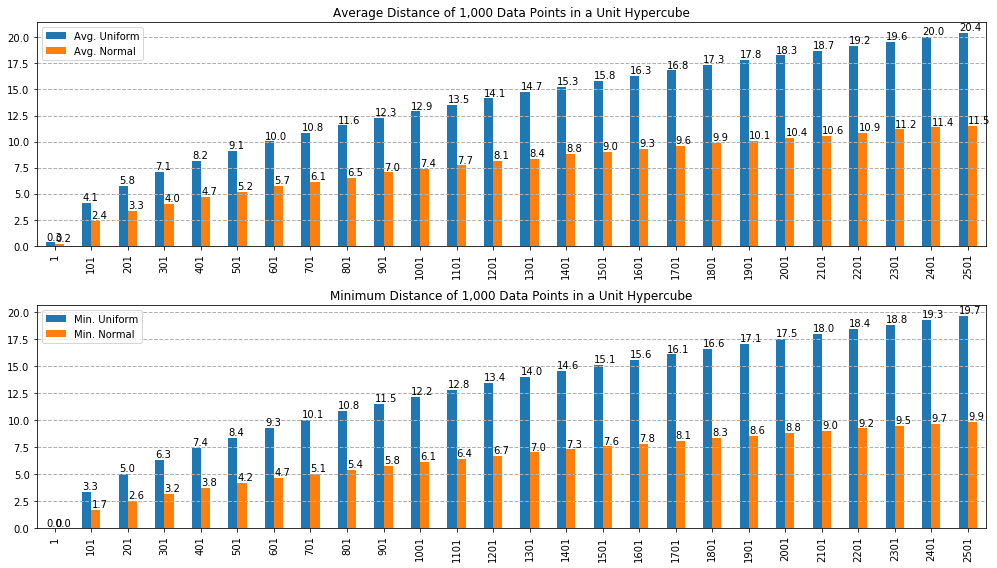

In [25]:
title = 'Distance of {:,.0f} Data Points in a Unit Hypercube'.format(n_points)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
distances[[ 'Avg. Uniform', 'Avg. Normal']].plot.bar(title='Average ' + title, ax=axes[0])
distances[[ 'Min. Uniform', 'Min. Normal']].plot.bar(title='Minimum ' + title, ax=axes[1])

for ax in axes:
    ax.grid(axis='y', lw=1, ls='--')
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + .005, p.get_height() + .25), fontsize=10)
fig.tight_layout();